## Saving Accounts Project 

The comparison between different bank saving plans in Singapore is not straightforward. The return rates depend on customer financial situation, described by several parameter related to customer income and spending behavior like salary or GIRO transactions, as well as the parameters related to insurance, investments and loans (bank products/services). 

The objective of this project is to compute and compare the saving account returns from 5 Singapore banks: DBS, OCBC, CitiBank, UOB and MayBank for a defined customer profile (input data from a customer).


In [1]:
#Import of necessary libraries
from gurobipy import *
import numpy as np
%matplotlib inline 
import seaborn as sns

In [2]:
#Input data from a customer:
AccountBalance=60000                    #Account Balance Amount
CreditedSalary=6000                     #Monthly Credited  Salary
CreditCardSpending=1000                 #Monthly Credit Card spending
GIRO_Amount=300                         #Monthly GIRO payments Amount
GIRO_BillNb= 3                          #Monthly number of GIRO payments
InvestTotal= 25000                      #Total Investments Amount(Unit Trust/Structured Deposits)
InvestMonthly=200                       #Monthly Investments Amount
InsuranceAnnual=5000                    #Annual Insurance Amount
InsuranceMonthly=100                    #Monthly Insurance Amount
HouseLoanTotal= 300000                  #Total House loan Amount
HouseLoanMonthly=1000                    #Monthly House loan Amount
LoanOthers=0                            #Number of other Loans
SavingMonthly=500                       #Monthly Savings Increment
BalanceDaily =50000                     #Minimum daily balance

#  Parameters shared by all models
M = 10000000

#### Model definition for each bank

In [3]:
def BestRate_DBS():
    #Specific parameters for DBS
    band25=min(AccountBalance,25000)                   # First $25000 band 
    band25_diff=max(0,AccountBalance-25000)            # Next $25000 band
    band50=min(AccountBalance,50000)                   # First $50000 band 
    band50_diff=max(0,AccountBalance-50000)            # Remaining amount band for Account Balance between $50000 and $100000
    band50_2=max(0,min(50000,AccountBalance-50000))    # Next $50000 band
    band100_diff= max(0,AccountBalance-100000)         # Remaining amount band for Account Balance above $100000
    st_rate=1.0005                                     # Standard Rate
    rate = np.array([[1.0005, 1.0005,1.0005],          # Rates for different conditions
                    [1.007, 1.013,1.02],
                     [1.009,1.015,1.022],
                     [1.011,1.018,1.024],
                     [1.012,1.019,1.025],
                     [1.013,1.028,1.038]
                    ])
    
    t=CreditedSalary+CreditCardSpending+InvestMonthly+InsuranceMonthly+HouseLoanMonthly   #Total transactions amount
    
    #count transaction types
    DBS_Trxns=[CreditCardSpending,InvestMonthly,InsuranceMonthly,HouseLoanMonthly]
    c=0
    for transaction in DBS_Trxns:
        if transaction>0:
            c=c+1
    if c==4:
        c=3
    
    #DBS Model
    br_DBS = Model("BestRate_DBS")
    Di,Dj = rate.shape
    x = br_DBS.addVars(Di,Dj, vtype=GRB.BINARY, name = "x")
    
    br_DBS.setObjective(quicksum((rate[i,0]*band25+st_rate*band25_diff)*x[i,0] for i in range(Di))+
                    quicksum((rate[i,1]*band50+st_rate*band50_diff)*x[i,1] for i in range(Di))+
                    quicksum((rate[i,1]*band50+rate[i,2]*band50_2+st_rate*band100_diff)*x[i,2] for i in range(Di)), 
                    GRB.MAXIMIZE)
    
    #contraints related to number of transaction type
    br_DBS.addConstrs(3+M*(1-x[i,2])>=c for i in range(Di))
    br_DBS.addConstrs(2+M*(1-x[i,1])>=c for i in range(Di))
    br_DBS.addConstrs(1+M*(1-x[i,0])>=c for i in range(Di))
    
    br_DBS.addConstrs(3-M*(1-x[i,2])<=c for i in range(Di))
    br_DBS.addConstrs(2-M*(1-x[i,1])<=c for i in range(Di))
    br_DBS.addConstrs(1-M*(1-x[i,0])<=c for i in range(Di))
    
    #contraints related to total amount of transactions
    br_DBS.addConstrs(0-M*(1-x[0,j])<=t for j in range(Dj))
    br_DBS.addConstrs(2000-M*(1-x[1,j])<=t for j in range(Dj))
    br_DBS.addConstrs(2500-M*(1-x[2,j])<=t for j in range(Dj))
    br_DBS.addConstrs(5000-M*(1-x[3,j])<=t for j in range(Dj))
    br_DBS.addConstrs(15000-M*(1-x[4,j])<=t for j in range(Dj))
    br_DBS.addConstrs(30000-M*(1-x[5,j])<=t for j in range(Dj))
    
    br_DBS.addConstrs(t<=2000+M*(1-x[0,j]) for j in range (Dj))
    br_DBS.addConstrs(t<=2500+M*(1-x[1,j]) for j in range (Dj))
    br_DBS.addConstrs(t<=5000+M*(1-x[2,j])for j in range(Dj))
    br_DBS.addConstrs(t<=15000+M*(1-x[3,j])for j in range(Dj))
    br_DBS.addConstrs(t<=30000+M*(1-x[4,j])for j in range(Dj))
    br_DBS.addConstrs(t<=M*(1-x[5,j])for j in range(Dj))
    
    #Only one rate form rate table can be chosen
    br_DBS.addConstr(quicksum((x[i,j]) for i in range(Di) for j in range(Dj)) ==1)
    
    return br_DBS

def BestRateOCBC():
    #OCBC Bank parameter
    band25_1=min(AccountBalance,25000)                   # First $25000 band 
    band25_2=max(0,min(AccountBalance-25000,25000))      # Next $25000 band
    band25_3=max(0,min(AccountBalance-50000,25000))      # Next $25000 band
    bandRemain=max(0,AccountBalance-75000)               # Remaining band
    st_rate=1.0005                                       # Standard Rate
    
    #OCBC Model
    br_OCBC = Model("BestRate_OCBC")
    criter = br_OCBC.addVars(5, vtype=GRB.BINARY,  name="criter")
    band=br_OCBC.addVars(4,  name="band")
    
    br_OCBC.setObjective(band25_1*(st_rate+0.004*criter[0]+0.001*criter[1]+0.004*criter[2]+0.004*criter[3]+0.004*criter[4])+
                         band25_2*(st_rate+0.008*criter[0]+0.002*criter[1]+0.008*criter[2]+0.008*criter[3]+0.004*criter[4])+
                         band25_3*(st_rate+0.012*criter[0]+0.004*criter[1]+0.012*criter[2]+0.012*criter[3]+0.004*criter[4])+
                         bandRemain*st_rate,GRB.MAXIMIZE)
    
    #contraints related to different criterias
    br_OCBC.addConstr(1800-M*(1-criter[0])<=CreditedSalary)
    br_OCBC.addConstr(500-M*(1-criter[1])<=SavingMonthly)
    br_OCBC.addConstr(2000-M*(1-criter[2])<=InsuranceAnnual)
    br_OCBC.addConstr(20000-M*(1-criter[3])<=InvestTotal)
    br_OCBC.addConstr(200000-M*(1-criter[4])<=BalanceDaily)
    
    return br_OCBC

def BestRate_CitiBank():
    #Citibank parameters
    st_rate=1.0001  #Standard Rate
    
    #Citibank Model
    br_Citi = Model("BestRate_Citi")
    criter = br_Citi.addVars(5, vtype=GRB.BINARY,  name="criter")
    band=br_Citi.addVars(2,  name="band")
    
    br_Citi.setObjective(band[0]*(st_rate+0.002*criter[0]+0.008*criter[1]+0.008*criter[2]+0.008*criter[3]+0.002*criter[4])+
                         band[1]*st_rate,GRB.MAXIMIZE)
    
    #contraints related to different criterias
    br_Citi.addConstr(250-M*(1-criter[0])<=CreditCardSpending)
    br_Citi.addConstr(50000-M*(1-criter[1])<=InvestTotal)
    br_Citi.addConstr(50000-M*(1-criter[2])<=InsuranceAnnual)
    br_Citi.addConstr(500000-M*(1-criter[3])<=HouseLoanTotal)
    br_Citi.addConstr(3000-M*(1-criter[4])<=SavingMonthly)
    
    #contraints related to bands
    br_Citi.addConstr(band[0]+band[1]==AccountBalance)
    br_Citi.addConstr(band[0]<=50000)
    
    br_Citi.setParam( 'OutputFlag', False )
    return br_Citi

def BestRate_UOB():
    #Specific parameters for UOB
    band15_1=min(AccountBalance,15000)                      # First $15000 band 
    band15_2=max(0,min(AccountBalance-15000,15000))         # Next $15000 band
    band15_3=max(0,min(AccountBalance-30000,15000))         # Next $15000 band
    band15_4=max(0,min(AccountBalance-45000,15000))         # Next $15000 band
    band15_5=max(0,min(AccountBalance-60000,15000))         # Next $15000 band
    bandRemain=max(0,AccountBalance-75000)                  # Remaining band
    st_rate=1.0005                                          # Standard Rate
    
    #UOB Model
    br_UOB = Model("BestRate_UOB")
    criter = br_UOB.addVars(3, vtype=GRB.BINARY,  name="criter")
    b=br_UOB.addVar(vtype=GRB.BINARY, name='binary')
    
    br_UOB.setObjective(band15_1*(1.0025*criter[0]+1.005*criter[1]+1.0005*criter[2])+
                         band15_2*(1.0025*criter[0]+1.0055*criter[1]+1.0005*criter[2])+
                         band15_3*(1.0025*criter[0]+1.0065*criter[1]+1.0005*criter[2])+
                         band15_4*(1.0025*criter[0]+1.008*criter[1]+1.0005*criter[2])+
                         band15_5*(1.0025*criter[0]+1.025*criter[1]+1.0005*criter[2])+
                         bandRemain*st_rate,GRB.MAXIMIZE)
    
    #contraints related to different criterias
    br_UOB.addConstr(250-M*(1-criter[0])<=CreditCardSpending)
    br_UOB.addConstr(250-M*(1-criter[1])-CreditCardSpending<=M*(1-b) )
    br_UOB.addConstr(2000-M*(1-criter[1])-CreditedSalary<=M*(1-b))
    br_UOB.addConstr(3-M*(1-criter[1])-GIRO_BillNb<=M*b)
    br_UOB.addConstr(criter[1]<=1-criter[0])
    br_UOB.addConstr(criter[0]<=1-criter[2])
    br_UOB.addConstr(criter[1]<=1-criter[2])
    
    return br_UOB

def BestRate_MayBank():
    #Specific parameters for Maybank
    band3=min(AccountBalance,3000)                      # First $3000 band 
    band47=max(0, min(AccountBalance-3000,47000))       # Next $47000 band
    bandRemain=max(0,AccountBalance-50000)              # Remaining band
    
    # Count of Number of eligible products
    c=0
    if CreditedSalary>=2000 or GIRO_Amount>=300:
        c=1
    if CreditCardSpending>=500:
        c=c+1
    if InvestTotal>=25000:
        c=c+1 
    if InsuranceAnnual>=5000:
        c=c+1   
    if HouseLoanTotal>=500000:
        c=c+1
    if LoanOthers>0:
        c=c+1
    c=min(c,3)

    br_MayBank = Model("BestRate_MayBank")
    prod_nb= br_MayBank.addVars(3, vtype=GRB.BINARY,  name="prod_nb")
    criter = br_MayBank.addVars(6, vtype=GRB.BINARY,  name="criter")
    
    br_MayBank.setObjective(band3*(1.001875+0.003*prod_nb[0]+0.008*prod_nb[1]+0.0275*prod_nb[2])+
                            band47*(1.0025+0.003*prod_nb[0]+0.008*prod_nb[1]+0.0275*prod_nb[2])+
                            bandRemain*(1.003125),GRB.MAXIMIZE)

    br_MayBank.addConstr(1+M*(1-prod_nb[0])>=c)                                     
    br_MayBank.addConstr(1-M*(1-prod_nb[0])<=c)   
    br_MayBank.addConstr(2+M*(1-prod_nb[1])>=c)                                     
    br_MayBank.addConstr(2-M*(1-prod_nb[1])<=c)   
    br_MayBank.addConstr(3+M*(1-prod_nb[2])>=c)                                     
    br_MayBank.addConstr(3-M*(1-prod_nb[2])<=c)   

    return br_MayBank

#### Results

Using license file c:\gurobi\gurobi.lic
Academic license - for non-commercial use only


<IPython.core.display.Javascript object>

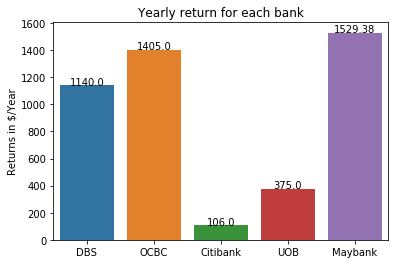

In [4]:
models=[BestRate_DBS(), BestRateOCBC(), BestRate_CitiBank(), BestRate_UOB(), BestRate_MayBank()]

BankNames=['DBS','OCBC','Citibank','UOB','Maybank']
Returns=[]
for model in models:
    m=model
    m.setParam( 'OutputFlag', False )
    m.optimize()
    Returns.append(m.objVal-AccountBalance)
Result=pd.DataFrame(Returns, index=['DBS','OCBC','Citibank','UOB','Maybank'],columns=['Returns'])
Result=Result.reset_index()

ax=sns.barplot(x=BankNames, y=Returns)
ax.set(ylabel='Returns in $/Year')
ax.set_title('Yearly return for each bank')
for index, row in Result.iterrows():
    ax.text(row.name,row.Returns+3, round(row.Returns,2), color='black', ha="center")